### Bibliotecas Usadas

In [98]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from scipy.optimize import linear_sum_assignment 
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

### Leitura do dataset

In [99]:
df = pd.read_csv('diabetes.csv')
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


### Part A)

#### 1)

- Separação entre features e target

In [100]:
X = df.drop(columns=['Outcome'])
y = df['Outcome']

Pipeline definido basicamente foi:

- Divisão entre treino e teste
- Definição dos ${k_values}$ de 2 a 11
- E por último o plot de SSE p/ cada um dos k clusters

-------------------------------------------

- Para isso, setamos usando kmeans o número k de cluster que vamos usar, no qual definimos um loop com cada um dos k solicitados para realizar assim o cálculo de SSE(sum of squared errors)

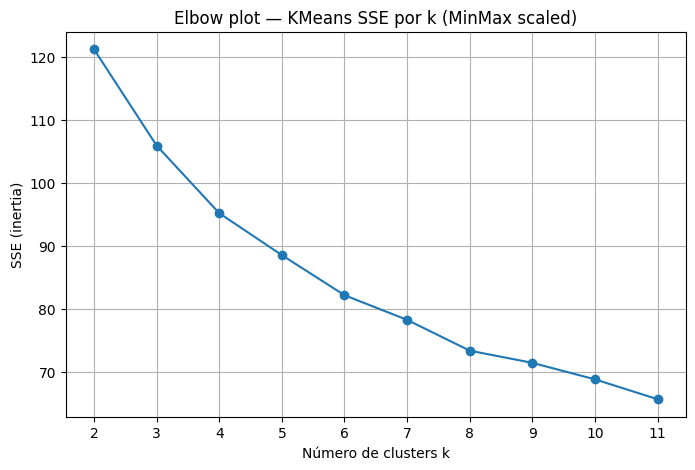

In [101]:
X_train, X_test, y_train, y_test = train_test_split( 
    X, y, test_size=0.2, random_state=42, stratify=y
)

k_values = list(range(2, 12))
max_iter = 500

scaler = MinMaxScaler()
X_scaled_full = scaler.fit_transform(X)

sse = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, max_iter=max_iter, random_state=42, n_init='auto')
    kmeans.fit(X_scaled_full)
    sse.append(kmeans.inertia_) #este inertia eh o sse

plt.figure(figsize=(8,5))
plt.plot(k_values, sse, marker='o')
plt.xticks(k_values)
plt.xlabel('Número de clusters k')
plt.ylabel('SSE (inertia)')
plt.title('Elbow plot — KMeans SSE por k (MinMax scaled)')
plt.grid(True)
plt.show()

- O que podemos obter como conclusão deste gráfico, é que a medida que o ${k}$ aumenta, o SSE diminui, o que era esperado, no qual quanto mais clusters a tendência é que se reduza o erro interno 
- Em que a partir do k=7, encontramos elbow, em que é o ponto onde a adição de mais clusters não traz um ganho significativo na redução do SSE, ou seja, conseguimos extrair análises de equilíbrio entre a simplicidade, poucos clusters, e o ajuste, minimização do SSE

Essa segunda parte, é uma complementação apenas que vamos analisar para esses mesmos ${k_{values}}$ de clusterização, a performance da acurácia quanto ao treino e ao teste

----------------------------------------------------------------------

- Para isso, criamos um Pipeline de dados da seguinte maneira: 
- Definomos o MinMaxScaler, para assim termos todas as variáveis na escala de 0 a 1, a fim de evitar que alguma das features assuma um peso indevido a ela quanto a classificação do outcome
- Aplicação da clusterização, com o k sendo o número de cluster definidos anteriormente de 2 a 11
- Calculamos a acurácia, definida nessa função no qual mapeamos os rótulos de cluster para rótulos verdadeiros usando linear_sum_assignment

    k  train_acc  test_acc
0   2   0.661238  0.668831
1   3   0.532573  0.500000
2   4   0.475570  0.435065
3   5   0.418567  0.337662
4   6   0.382736  0.337662
5   7   0.400651  0.324675
6   8   0.312704  0.279221
7   9   0.275244  0.266234
8  10   0.249186  0.227273
9  11   0.236156  0.220779


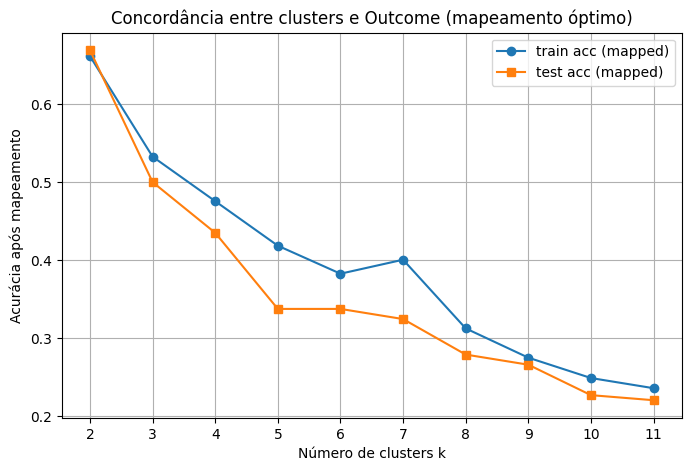

In [102]:
def cluster_accuracy(y_true, y_pred_clusters):
    #construção da matriz de confusao
    cm = confusion_matrix(y_true, y_pred_clusters)

    #queremos maximizar o total de acertos => minimizar custo negativo
    #a função linear_sum_assignment minimiza; então passamos -cm
    row_ind, col_ind = linear_sum_assignment(-cm)
    mapping = dict(zip(col_ind, row_ind))  #cluster_label -> true_label

    #mapear previsões de cluster para rótulos reais
    y_mapped = np.vectorize(lambda c: mapping.get(c, -1))(y_pred_clusters)

    return accuracy_score(y_true, y_mapped), mapping

#para cada k usando apenas o pipeline (scaler fit no TRAIN).
results = {'k': [], 'train_acc': [], 'test_acc': []}

for k in k_values:
    #pipeline com scaler (fit apenas em X_train) + kmeans
    pipe = Pipeline([
        ('scaler', MinMaxScaler()),
        ('kmeans', KMeans(n_clusters=k, max_iter=500, random_state=42, n_init='auto'))
    ])

    #ajustar usando X_train, não passar y_train
    pipe.fit(X_train)

    #prever clusters (pipeline aplica scaler internamente)
    train_clusters = pipe.predict(X_train)
    test_clusters = pipe.predict(X_test)

    #mapear clusters -> rótulos usando o conjunto de treino (mapeamento baseado no train)
    train_acc, mapping = cluster_accuracy(y_train, train_clusters)

    #aplicar mapping ao test e calcular acurácia
    y_test_mapped = np.vectorize(lambda c: mapping.get(c, -1))(test_clusters)
    test_acc = accuracy_score(y_test, y_test_mapped)

    results['k'].append(k)
    results['train_acc'].append(train_acc)
    results['test_acc'].append(test_acc)

#printando os resultados
res_df = pd.DataFrame(results)
print(res_df)

#plot da acurácia por cada k
plt.figure(figsize=(8,5))
plt.plot(res_df['k'], res_df['train_acc'], marker='o', label='train acc (mapped)')
plt.plot(res_df['k'], res_df['test_acc'], marker='s', label='test acc (mapped)')
plt.xticks(k_values)
plt.xlabel('Número de clusters k')
plt.ylabel('Acurácia após mapeamento')
plt.title('Concordância entre clusters e Outcome (mapeamento óptimo)')
plt.legend()
plt.grid(True)
plt.show()

#### 2)

- A ideia é retornar um rótulo para cada cluster, com k=6, e para cada um destes vamos contar quantas observações(1 ou 0) temos, e o rótulo desse cluster será a classe que predominar
- Defini quando chegamos ao empate na predominância de classe, classificamos como não diabético, porque seria necessário realizar algumas medidas que às vezes não caberia a tais pacientes como entrada de medicaçãoes como insulina a pessoas que não estão neste grupo teria grande impacto
- No final, compara-se o rótulo previsto do cluster com o outcome verdadeiro, e a partir disso criamos a matriz de confusão e os respectivas métricas, como precisão, recall f_score 

In [103]:
k = 6
kmeans = KMeans(n_clusters=k, max_iter=500, random_state=42, n_init='auto')
clusters = kmeans.fit_predict(X_scaled_full)  #array com rótulos de cluster para cada observação

#descobrir a classe majoritária em cada cluster
cluster_to_majority = {}
cluster_counts = {}

for c in range(k):
    idx = np.where(clusters == c)[0]
    labels_in_cluster = y.iloc[idx].values
    #se cluster vazio: escolhemos label 0 por default, já que não temos informação p/ classificar
    if len(labels_in_cluster) == 0:
        majority_label = 0
    else:
        counts = np.bincount(labels_in_cluster, minlength=2)  #[count_0, count_1]
        #tie-breaker: escolher menor rótulo (0) em caso de empate
        majority_label = int(np.argmin(counts))
    cluster_to_majority[c] = majority_label
    cluster_counts[c] = {'size': len(labels_in_cluster), 'counts': np.bincount(labels_in_cluster, minlength=2)}

#aplicar o rótulo majoritário a todas as observações (classificação final)
y_pred_from_clusters = np.array([cluster_to_majority[c] for c in clusters])

#métricas
cm = confusion_matrix(y, y_pred_from_clusters)
acc = accuracy_score(y, y_pred_from_clusters)
precision, recall, f1, _ = precision_recall_fscore_support(y, y_pred_from_clusters, average='binary', pos_label=1)

#printando tudo
print("Distribuição por cluster (cluster: size, [count_0, count_1], majority_label):")
for c in range(k):
    print(f"  cluster {c}: size={cluster_counts[c]['size']}, counts={list(cluster_counts[c]['counts'])}, majority={cluster_to_majority[c]}")

print("\nMatriz de Confusão (true rows, pred columns):")
print(cm)
print(f"\nAcurácia: {acc:.4f}")
print(f"Precisão (classe 1): {precision:.4f}")
print(f"Recall (classe 1): {recall:.4f}")
print(f"F1-score (classe 1): {f1:.4f}")

print("\nRelatório detalhado por classe:")
print(classification_report(y, y_pred_from_clusters, digits=4))

Distribuição por cluster (cluster: size, [count_0, count_1], majority_label):
  cluster 0: size=134, counts=[np.int64(61), np.int64(73)], majority=0
  cluster 1: size=280, counts=[np.int64(254), np.int64(26)], majority=1
  cluster 2: size=69, counts=[np.int64(43), np.int64(26)], majority=1
  cluster 3: size=35, counts=[np.int64(19), np.int64(16)], majority=1
  cluster 4: size=125, counts=[np.int64(74), np.int64(51)], majority=1
  cluster 5: size=125, counts=[np.int64(49), np.int64(76)], majority=0

Matriz de Confusão (true rows, pred columns):
[[110 390]
 [149 119]]

Acurácia: 0.2982
Precisão (classe 1): 0.2338
Recall (classe 1): 0.4440
F1-score (classe 1): 0.3063

Relatório detalhado por classe:
              precision    recall  f1-score   support

           0     0.4247    0.2200    0.2899       500
           1     0.2338    0.4440    0.3063       268

    accuracy                         0.2982       768
   macro avg     0.3293    0.3320    0.2981       768
weighted avg     0.358

Geralmente, não é um bom modelo de classificação quanto comparamos com um classificador supervisionado, por exemplo, isso porque: 
- Clustering é não supervisionado, no qual KMeans tenta agrupar pontos próximos geometricamente(minimização da variância intra-cluster), não otimiza separação entre classes, no qual os clusters podem agrupar subclasses da mesma classe ou misturar classes
- Perda de informação: quando acontece a rotulação por classe majoritária, ignoramos a variação dentro do cluster, em que, por exemplo, os pontos minoritários daquele cluster irão ficar rotulados de forma errada 
- É sensível quanto a escolha do k, e isto pode ser observado na questão 1), na qual não há garantia que k corresponda ao "número natural" de classes
- Desbalancemanto, no sentido de que se uma classe for dominante globalmente, muitos clusters poderão ficar com a classe dominante levando a alta acurácia aparente, mas há má performance em detectar a classe minoritária, no qual observamos a classe 1 com recall mais baixo (0.556), enquanto a 0 (0.780)
- Não explora rótulos durante o aprendizado, modelos supervisionados são otimizados para prever o outcome e tipicamente entregam desempenho superior 

#### 3)

Vamos treinar novamente, exatamente como no exercício anterior, só que agora vamos realizar uma análise mais detalhada de alguns pontos: 
- Distribuição de classes, os outcomes, dentro de cada cluster
- As coordenadas dos centróides de cada cluster 
- Vamos escolher, ao final disto, os 3 clusters mais discriminitivos, dentre os 6, ou seja, aqueles em que a proporção de 0/1 é mais desigual
- E partir diss, finalmente, vamos interpretar clinicamente o que caracteriza cada um dos clusters

In [104]:
k = 6
kmeans = KMeans(n_clusters=k, max_iter=500, random_state=42, n_init='auto')
clusters = kmeans.fit_predict(X_scaled_full)

#analise da distribuição de classes em cada cluster
cluster_info = []

for c in range(k):
    mask = (clusters == c)
    subset_y = y[mask]
    n0 = (subset_y == 0).sum()
    n1 = (subset_y == 1).sum()
    total = len(subset_y)
    pct0 = 100 * n0 / total if total > 0 else 0
    pct1 = 100 * n1 / total if total > 0 else 0
    cluster_info.append({
        'cluster': c,
        'total': total,
        'class_0': n0,
        'class_1': n1,
        'pct_class_0': pct0,
        'pct_class_1': pct1
    })

cluster_df = pd.DataFrame(cluster_info)
print("\n=== Distribuição de classes por cluster ===")
print(cluster_df.sort_values('cluster'))

#centros dos clusters
centers = pd.DataFrame(
    kmeans.cluster_centers_,
    columns=X.columns
)
print("\n=== Coordenadas dos centróides (em escala normalizada 0–1) ===")
print(centers.round(3))

#identificar os 3 clusters mais discriminativos
#(com maior diferença percentual entre pct_class_0 e pct_class_1)
cluster_df['abs_diff'] = abs(cluster_df['pct_class_0'] - cluster_df['pct_class_1'])
top3 = cluster_df.sort_values('abs_diff', ascending=False).head(3)
print("\n=== 3 clusters mais discriminativos ===")
print(top3[['cluster', 'total', 'pct_class_0', 'pct_class_1', 'abs_diff']])

#os centróides desses 3 clusters
print("\n=== Centrós dos 3 clusters mais discriminativos ===")
print(centers.loc[top3['cluster']].round(3))


=== Distribuição de classes por cluster ===
   cluster  total  class_0  class_1  pct_class_0  pct_class_1
0        0    134       61       73    45.522388    54.477612
1        1    280      254       26    90.714286     9.285714
2        2     69       43       26    62.318841    37.681159
3        3     35       19       16    54.285714    45.714286
4        4    125       74       51    59.200000    40.800000
5        5    125       49       76    39.200000    60.800000

=== Coordenadas dos centróides (em escala normalizada 0–1) ===
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  \
0        0.111    0.751          0.610          0.345    0.248  0.552   
1        0.104    0.498          0.549          0.239    0.069  0.447   
2        0.350    0.679          0.659          0.052    0.010  0.440   
3        0.213    0.592          0.000          0.015    0.000  0.383   
4        0.283    0.618          0.604          0.017    0.011  0.474   
5        0.502    0

Vemos que os clusters mais discriminatórios foram {1,2} a classe predominante foi a 0, pacientes não diabéticos, apesar da 2 ter uma tendência bem mais ao equilíbrio, e que no caso do cluster {5} a classe predominante foi a 1, dos diabéticos
-  A glicose é a variável mais discriminante entre pacientes diabéticos e não diabéticos.
Os clusters 2 e 5 mostram valores consistentemente altos, sugerindo glicemia elevada, tal fato talvez explicaria a tendência maior ao equilíbrio pelo cluster 2.
- Clusters 2 e 5 mantêm padrão de pressão arterial acima da média, o que é comum entre pacientes com diabetes tipo 2 devido a comorbidades.
- O IMC elevado é um importante fator de risco — cluster 5 se destaca com maior prevalência de diabetes, coerente com o valor mais alto.
- Pacientes do cluster 5 podem apresentar hiperinsulinemia compensatória, típica em fases iniciais do diabetes tipo 2
- A idade aumenta gradualmente do cluster 1 para o 2, acompanhando o risco de diabetes, no qual o cluster 1 (90% não diabético) é o mais jovem, enquanto o 2 (misto) é mais idoso
- Gravidezes múltiplas aumentam o risco de diabetes gestacional e subsequente diabetes tipo 2, condizente com o perfil do cluster 5
Clusters 5 (diabético) apresentam maior espessura cutânea, sinal de adiposidade

- Assim pegando as informações que temos dois 3 clusters mais discriminativos, temos a seguinte disposição, isso em formato de heatmap e de radar

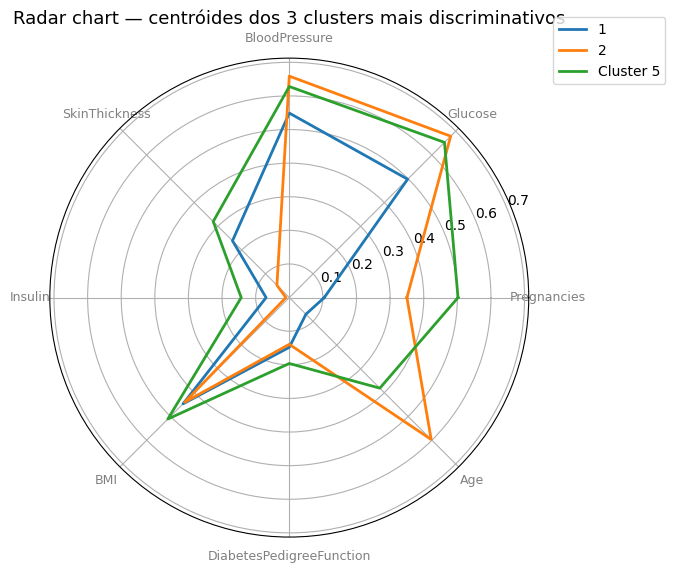

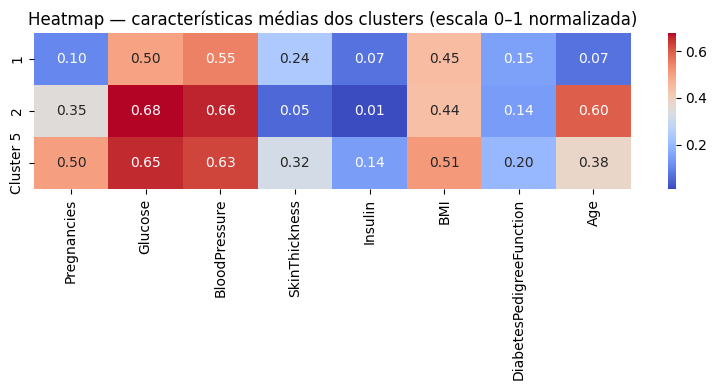

In [105]:
centers_top3 = pd.DataFrame({
    'Pregnancies': [0.104, 0.350, 0.502],
    'Glucose': [0.498, 0.679, 0.653],
    'BloodPressure': [0.549, 0.659, 0.628],
    'SkinThickness': [0.239, 0.052, 0.320],
    'Insulin': [0.069, 0.010, 0.143],
    'BMI': [0.447, 0.440, 0.511],
    'DiabetesPedigreeFunction': [0.148, 0.139, 0.196],
    'Age': [0.070, 0.597, 0.381]
}, index=['1', '2', 'Cluster 5'])

#radar plot
features = centers_top3.columns.tolist()
num_vars = len(features)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1] 

plt.figure(figsize=(7, 7))
for i, row in centers_top3.iterrows():
    values = row.tolist()
    values += values[:1]
    plt.polar(angles, values, label=i, linewidth=2)

plt.xticks(angles[:-1], features, color='grey', size=9)
plt.title("Radar chart — centróides dos 3 clusters mais discriminativos", size=13)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()

# heatmap comparativo
plt.figure(figsize=(8, 4))
sns.heatmap(centers_top3, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Heatmap — características médias dos clusters (escala 0–1 normalizada)")
plt.tight_layout()
plt.show()

### Part B)

#### 1)

- O objetivo agora é aplicar Análise de Componentes Principais (PCA) para reduzir a dimensionalidade dos dados e avaliar o quanto da variabilidade total é explicada pelos componentes principais.

Para isso, vamos seguir o seguinte pipeline:
- Normalizamos os dados, com MinMaxScaler, igual da parte A)
- Aplicamos o PCA
- Plotamos o gráfico da variância explicada acumulada 
- Determinamos quantos componentes principais são necessários para reter ao menos 80% da variância total

------------------------------------------------------------------------------

Definimos esse passo a passo, baseado no que:
- o PCA é sensível à escala de dados, a normalização garante que todas as variáveis contribuam de forma mais justa
- o PCA basicamente transforma as features originais em novas combinações lineares que maximizam a variância dos dados, no qual o 1 componente explica a maior parte da variância, o 2 explica a maior parte da sobra
- a variância, mostra quanta da informação dos dados originais é retida, se ficarmos com os primeiros n componentes, por exemplo se os 3 componentes de 8 explicam 80% ou mais da variância, podemos de 8 dimensões reduzirmos para 3 apenas

- Primeiros setamos o PCA, em que quando não passamos parâmetros aplica o PCA completo em todos os componentes
- O atributo *explained_variance_ratio_* indica a fração de variância explicada por cada componente 
- E por último, o cálculo e plot da variância acumulada

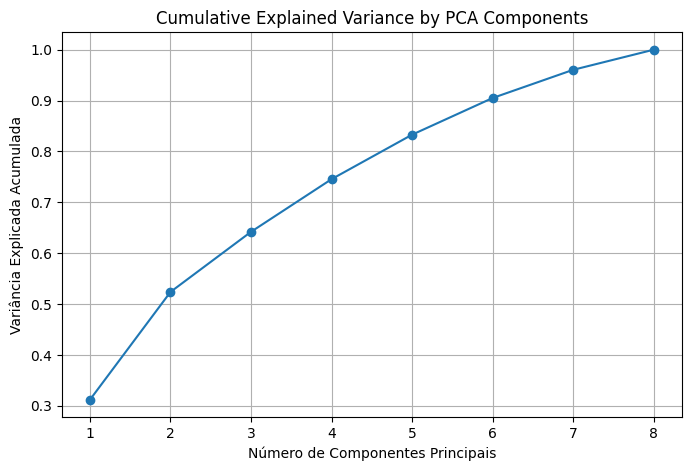

Número de componentes necessários para reter >= 80% da variância: 5
Componente 1: 31.19% da variância
Componente 2: 21.19% da variância
Componente 3: 11.82% da variância
Componente 4: 10.35% da variância
Componente 5: 8.74% da variância
Componente 6: 7.21% da variância
Componente 7: 5.54% da variância
Componente 8: 3.96% da variância


In [106]:
pca = PCA()
X_pca = pca.fit_transform(X_scaled_full)

#variância explicada
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

#plotando a variância explicada acumulada
plt.figure(figsize=(8,5))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.xlabel('Número de Componentes Principais')
plt.ylabel('Variância Explicada Acumulada')
plt.title('Cumulative Explained Variance by PCA Components')
plt.grid(True)
plt.show()

#determinando quantos componentes mantêm >= 80% da variância
n_components_80 = np.argmax(cumulative_variance >= 0.80) + 1
print(f"Número de componentes necessários para reter >= 80% da variância: {n_components_80}")

#variância de cada componente
for i, var in enumerate(explained_variance, start=1):
    print(f"Componente {i}: {var*100:.2f}% da variância")

- Nesse caso, interpretamos que, podemos reduzir o espaço de 8 dimensões, que são as features originais, para 5, mantendo 80% da informação, mais especificamente 83,29%.
- Plotamos os dados nas duas primeiras componentes principais (PC1 e PC2) para melhorar ainda mais a visualização de cada um dos componentes

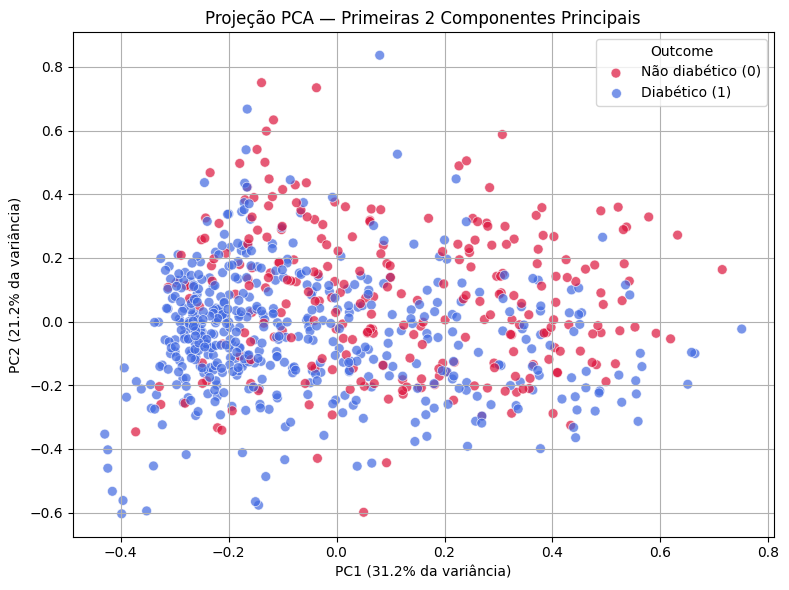

In [107]:
pca_df = pd.DataFrame(X_pca[:, :2], columns=['PC1', 'PC2'])
pca_df['Outcome'] = y.values

# plot 2D
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=pca_df,
    x='PC1', y='PC2',
    hue='Outcome',
    palette={0: 'royalblue', 1: 'crimson'},
    alpha=0.7,
    s=50
)

plt.title('Projeção PCA — Primeiras 2 Componentes Principais')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% da variância)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% da variância)')
plt.legend(title='Outcome', labels=['Não diabético (0)', 'Diabético (1)'])
plt.grid(True)
plt.tight_layout()
plt.show()

#### 2)

- Vamos projetar então os dados do primeiro componente principal, que é a feature que tem maior representatividade na explicação na variância dos dados
- Vamos também, plotar a distribuição das duas classes ao longo desse eixo
- E por último analisar o gráfico quanto a separabilidade das classes, ou seja, se o PCA consegue distinguir por ele prórprio, pacientes c/ ou sem diabetes 

- Setando comoo parâmetro *n_components=1* pegamos somente o PC1, que concentra a maior parte da variação dos dados
- Cada linha do dataset vai ser reduzida a um único valor de escalar

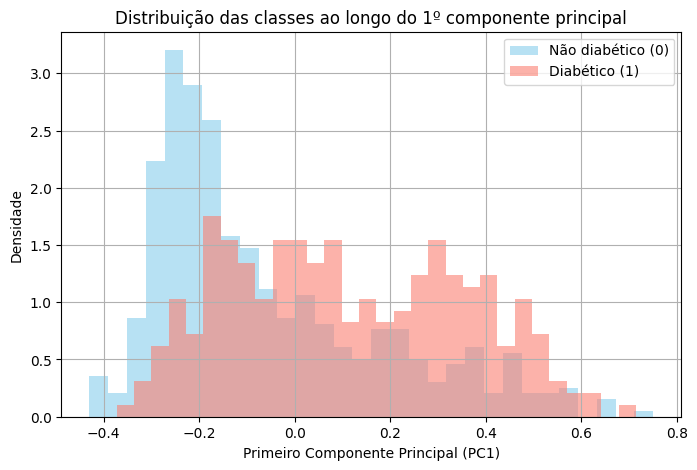

In [108]:
pca = PCA(n_components=1)
X_pca = pca.fit_transform(X_scaled_full)

# === 4. Plotar a distribuição de classes ao longo do PC1 ===
plt.figure(figsize=(8,5))
plt.hist(
    X_pca[y == 0], bins=30, alpha=0.6, label='Não diabético (0)',
    color='skyblue', density=True
)
plt.hist(
    X_pca[y == 1], bins=30, alpha=0.6, label='Diabético (1)',
    color='salmon', density=True
)
plt.title('Distribuição das classes ao longo do 1º componente principal')
plt.xlabel('Primeiro Componente Principal (PC1)')
plt.ylabel('Densidade')
plt.legend()
plt.grid(True)
plt.show()

- As duas classes (azul = não diabético, vermelho = diabético) apresentam sobreposição significativa ao longo de PC1

- Entretanto, há uma leve tendência de deslocamento: a distribuição dos diabéticos (1) tende a estar mais à direita, indicando valores maiores no eixo do PC1, e os não diabéticos(0) com pico de concentração mais a esquerda, no qual dos diabéticos não a esse pico mais sim uma distribuição mais suave a direita do ao longo do eixo x mais a direita

- O PC1 é uma combinação linear das variáveis originais (Glucose, BMI, Age, ...), que explica a maior parte da variância total

- Como o PCA não usa rótulos, a separação não é otimizada para distinguir classes, apenas para capturar a estrutura dos dados

- A sobreposição mostra que, embora as variáveis associadas ao PC1 (principalmente glicose e idade) tenham relação com o diabetes, essa relação não é linear e exclusiva o suficiente para separar completamente as classes

#### 3)

- Basicamente vamos aplicar LDA(linear discriminant analysis) sobre o dataset de diabetes, no qual diferentemente do PCA, o LDA usa rótulos do target para encontrar a direção que melhor separa as classes  
- Além disso, vamos projetar cada observação em u único componente do discriminante(p/ dois grupos/classes o LDA fornece 1 componente)
- E por fim, plotamos a distribuição de classes ao longo desse eixo LDA

- No qual o LDA é superversionado, busca a direção que maximiza a razão entre variância entre classes e variância dentro das classes, no qual para duas classes o LDA vai retornar somente um componente
- Inicialmente, invocamos o LDA passando como parâmetro o número de componentes desejado que nesse caso é 1
- Depois, calculamos a direção do discriminante e projeta os dados nessa direção

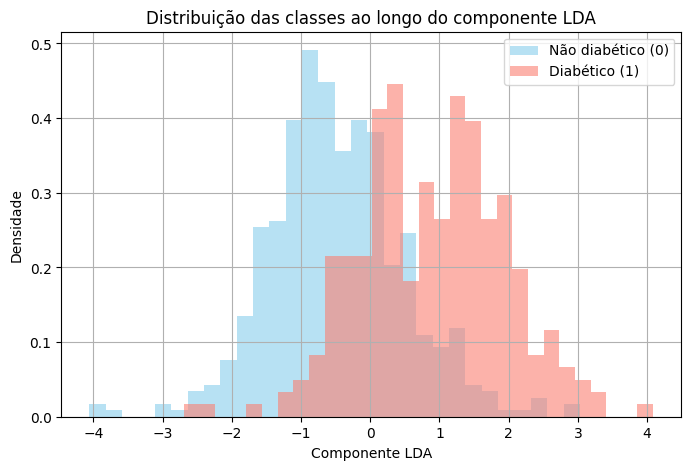

In [109]:
lda = LinearDiscriminantAnalysis(n_components=1)  # duas classes -> 1 componente
X_lda = lda.fit_transform(X_scaled_full, y)

# === 4. Plotar distribuição das classes ao longo do componente LDA ===
plt.figure(figsize=(8,5))
plt.hist(
    X_lda[y == 0], bins=30, alpha=0.6, label='Não diabético (0)',
    color='skyblue', density=True
)
plt.hist(
    X_lda[y == 1], bins=30, alpha=0.6, label='Diabético (1)',
    color='salmon', density=True
)
plt.title('Distribuição das classes ao longo do componente LDA')
plt.xlabel('Componente LDA')
plt.ylabel('Densidade')
plt.legend()
plt.grid(True)
plt.show()

O componente LDA mostra uma separação muito mais clara entre diabéticos e não diabéticos do que o PC1 do PCA

Classe 0 (não diabético): concentrada em valores negativos ou menores
Classe 1 (diabético): concentrada em valores positivos ou maiores

Essa diferença explica por que LDA pode ser usado como classificador supervisionado, enquanto PCA sozinho não garante separação de classes, no qual de forma comparativa podemos observar, as diferenças entre PCA e LDA: 

- Objetivo:	Maximizar variância	/ Maximizar separação entre classes
- Componentes:	Múltiplos (dependendo da variância)	/ C = número de classes - 1
- Separação de classes:	Pode não separar bem /	Geralmente separa muito melhor
- Interpretação:	Explorar estrutura geral /	Classificação e discriminante

#### 4)

Basicamente temos que o nosso problema inicial sempre foi criar uma regra discriminante que conseguia separar pacientes diabéticos, dos não diabéticos

Dessa forma, comparando os métodos utilizados nessa segunda parte: 
- PCA: é não supervisionado, reduz a dimensionalidade buscando maximizar a variância geral
- LDA: é supervisionado, reduz a dimensionalidade buscando maximizar a separação entre as classes 

No qual analisando as diferenças conceituais entre os dois métodos:

PCA: 
- Olha apenas a variância dos dados 
- O PC1 pode não separar as classes, pois não usa informação de rótulo, no qual pode-se observar que no exercício anterior acontece muito mais sobreposição de classe no PCA do que no LDA
- Ou seja, não é ideal para construção de regra determinante
- Apesar disso, é útil para redução de ruído ou compressão de dados, todavia demandaria um modelo supervisionado a ser aplicado depois

LDA: 
- Considera o rótulo das classes 
- Para as duas classes, produz um componente que maximiza a separação entre médias das classes e minimiza a dispersão dentro de cada classe, no qual há a menor sobreposição entre as classes quando comparado com PCA, como dito anteriormente também
- No qual, basicamente projetando os dados sobre o componente discriminante, você obtém um eixo de separação já otimizado
- Em que isso, permite o estabelecimento de um threshold/regra discriminante mais simples, como LDA < t -> classe 0, caso contrário, classe 1
- Ou seja, classificação mais precisa 

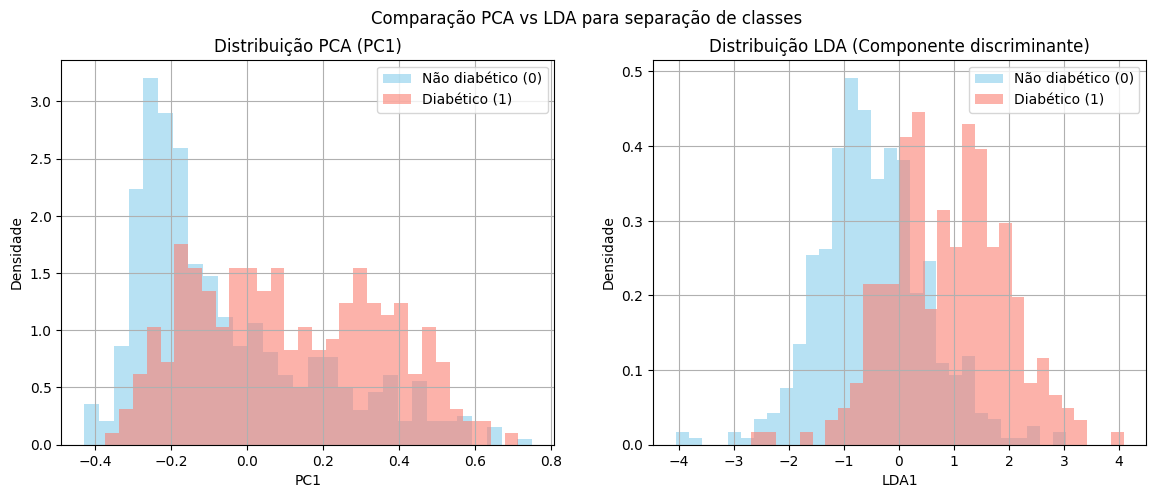

In [110]:
pca = PCA(n_components=1)
X_pca = pca.fit_transform(X_scaled_full)

lda = LinearDiscriminantAnalysis(n_components=1)
X_lda = lda.fit_transform(X_scaled_full, y)

#comparar os dois lado a lado
fig, axes = plt.subplots(1, 2, figsize=(14,5))

#PCA
axes[0].hist(
    X_pca[y==0], bins=30, alpha=0.6, label='Não diabético (0)',
    color='skyblue', density=True
)
axes[0].hist(
    X_pca[y==1], bins=30, alpha=0.6, label='Diabético (1)',
    color='salmon', density=True
)
axes[0].set_title('Distribuição PCA (PC1)')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('Densidade')
axes[0].legend()
axes[0].grid(True)

#LDA
axes[1].hist(
    X_lda[y==0], bins=30, alpha=0.6, label='Não diabético (0)',
    color='skyblue', density=True
)
axes[1].hist(
    X_lda[y==1], bins=30, alpha=0.6, label='Diabético (1)',
    color='salmon', density=True
)
axes[1].set_title('Distribuição LDA (Componente discriminante)')
axes[1].set_xlabel('LDA1')
axes[1].set_ylabel('Densidade')
axes[1].legend()
axes[1].grid(True)

plt.suptitle('Comparação PCA vs LDA para separação de classes')
plt.show()